In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import DataLoader, ConcatDataset, SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np

from dataset import ImageTableDataset
from model import MultimodalModel
from train import train

2022-12-19 14:41:17.433891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# ----- Dataset -----
print("Loading datasets...")

batch_size = 1

train_dataset = ImageTableDataset("train", table_filename="tabular_data_branch/temp.csv")
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageTableDataset("val", table_filename="tabular_data_branch/temp.csv")
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataset = ConcatDataset([train_dataset, val_dataset])

k = 2
splits = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
# splits = KFold(n_splits=k, shuffle=True, random_state=42)

Loading datasets...


/Users/michelleespranita/Documents/Sem3/MLMI/Notebooks/mlmi-prototype/dataset.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.tab_df.drop(["Mortality"], axis=1, inplace=True)
/Users/michelleespranita/Documents/Sem3/MLMI/Notebooks/mlmi-prototype/dataset.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.tab_df.drop(["Mortality"], axis=1, inplace=True)


In [4]:
len(dataset)

8

In [5]:
labels = [dataset[i]['label'] for i in range(len(dataset))]

In [6]:
labels

[0, 1, 1, 1, 1, 0, 0, 0]

In [7]:
# ----- Model -----
print("Creating model...")
model = MultimodalModel()

Creating model...


2022-12-19 14:41:23.800525: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
splits.split(dataset, labels)

<generator object _BaseKFold.split at 0x156534c10>

In [9]:
# ----- Training -----
print("Start training...")
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
config = {
    "learning_rate": 0.001,
    "max_epochs": 50,
    "print_every_n": 10,
    "validate_every_n": 10,
    "experiment_name": "baseline"
}

Start training...


In [14]:
results = {"val_acc": [], "val_auc": []}
for fold, (train_idx, val_idx) in enumerate(splits.split(dataset, labels)):
    print('Fold {}'.format(fold + 1))
    
    print(train_idx, val_idx)
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

    history = train(model, train_dataloader, val_dataloader, device, config)
    results["val_acc"].append(history["val_acc"])
    results["val_auc"].append(history["val_auc"])
#     results["val_sn"].append(history["val_sn"])
#     results["val_sp"].append(history["val_sp"])
#     results["val_ppv"].append(history["val_ppv"])
#     results["val_npv"].append(history["val_npv"])
#     results["val_mcc"].append(history["val_mcc"])

print("Validation accuracy:", torch.mean(torch.Tensor(results["val_acc"])).item())
print("Validation AUC:", torch.mean(torch.Tensor(results["val_auc"])).item())
# print("Validation SN (Recall):", torch.mean(results["val_sn"]).item())
# print("Validation SP (Specificity):", torch.mean(results["val_sp"]).item())
# print("Validation PPV:", torch.mean(results["val_ppv"]).item())
# print("Validation NPV:", torch.mean(results["val_npv"]).item())
# print("Validation MCC:", torch.mean(results["val_mcc"]).item())

Fold 1
[2 4 5 7] [0 1 3 6]
pred before squeeze torch.Size([1, 1])
pred after torch.Size([])
pred tensor(0.5346, grad_fn=<SqueezeBackward0>)
gt torch.Size([1])


/Users/michelleespranita/Documents/Sem3/MLMI/Notebooks/mlmi-prototype/model.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids = torch.tensor(torch.cat([torch.zeros(batch_size, num_img_tokens), torch.ones(batch_size, num_table_tokens)], dim=1), dtype=torch.int32)


ValueError: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.

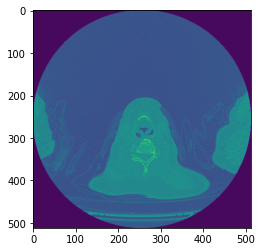

In [56]:
import pydicom as dicom
import matplotlib.pylab as plt

# specify your image path
image_path = 'image_data_branch/Patient 1/CT/I1000000.dcm'
ds = dicom.dcmread(image_path)

plt.imshow(ds.pixel_array)

In [72]:
ds.RescaleSlope

'1.0'

In [58]:
ds.pixel_array

array([[-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       ...,
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048]], dtype=int16)

In [73]:
np.min(ds.pixel_array)

-2168

In [74]:
np.max(ds.pixel_array)

2293

In [68]:
image_format = '.jpg' # or '.png'

cv2.imwrite("test.jpg", ds.pixel_array)

True

In [53]:
import cv2

In [65]:
img = cv2.imdecode(np.fromfile("image_data_branch/sample_image_dataset/Patient 1/CT/IMG-0001-00001.jpg", dtype=np.uint8), cv2.IMREAD_GRAYSCALE)

In [66]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [69]:
img = cv2.imdecode(np.fromfile("test.jpg", dtype=np.uint8), cv2.IMREAD_GRAYSCALE)

In [70]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)